In [163]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import sys
from gensim.models import ldamodel, CoherenceModel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import re
import string
import spacy
import pickle

In [164]:
df = pd.read_csv('JEOPARDY_CSV.csv')
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [165]:
df.columns = ['show_id', 'date', 'round', 'category', 'value', 'question', 'answer']

In [166]:
df['value'].replace({'None': '$0'}, inplace=True)

In [167]:
df['value'] = df['value'].apply(lambda x: int(x[1:].replace(',',''))) #remove $ remove comma and convert to int

In [168]:
df['year'] = df['date'].apply(lambda x: int(x[:4]))

In [169]:
df.head()

,show_id,date,round,category,value,question,answer,year
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004


### Split df by value  
Here we split the data into groups based on question value. The analytical goal is to analyze the difficulty of questions across years by dollar value of each question. Therefore, it's important to only include values where the dollar value represents the difficulty of the question and ignore values like daily doubles and final jeopardy where the player determines the value of their response. Since the values on the board have changed over the years, we can't necessarily use the divisible-by-100 pattern that's used on Jeopardy today. Instead, we have taken \\$2000 as the maximum point value and binned all lower values into groups of \\$200.

In [170]:
df.value.unique()

array([  200,   400,   600,   800,  2000,  1000,  1200,  1600,  3200,
           0,  5000,   100,   300,   500,  1500,  4800,  1800,  1100,
        2200,  3400,  3000,  4000,  6800,  1900,  3100,   700,  1400,
        2800,  8000,  6000,  2400, 12000,  3800,  2500,  6200, 10000,
        7000,  1492,  7400,  1300,  7200,  2600,  3300,  5400,  4500,
        2100,   900,  3600,  2127,   367,  4400,  3500,  2900,  3900,
        4100,  4600, 10800,  2300,  5600,  1111,  8200,  5800,   750,
        7500,  1700,  9000,  6100,  1020,  4700,  2021,  5200,  3389,
        4200,     5,  2001,  1263,  4637,  3201,  6600,  3700,  2990,
        5500, 14000,  2700,  6400,   350,  8600,  6300,   250,  3989,
        8917,  9500,  1246,  6435,  8800,  2222,  2746, 10400,  7600,
        6700,  5100, 13200,  4300,  1407, 12400,  5401,  7800,  1183,
        1203, 13000, 11600, 14200,  1809,  8400,  8700, 11000,  5201,
        1801,  3499,  5700,   601,  4008,    50,  2344,  2811, 18000,
        1777,  3599,

In [171]:
# only take rows from Jeopardy and Double Jeopardy
df_ = df.loc[(df['round'] == 'Jeopardy!') | (df['round'] == 'Double Jeopardy!')]
#df _ df_[df_['value'].isin([3, 6])]

# only takes values <= $2000
df_ = df_[df_['value']<=2000]
df_ = df_.sort_values('value')

# bin dollar values into groups of every $200
bins =  np.arange(0, 18000, 200)
ind = np.digitize(df_['value'], bins)

# split into separate dfs based on dollar value of question
dfs= [x for _, x in df_.groupby(ind)]

# Perform LDA on each group separately

In [172]:
# adapted from https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Stemming
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    all_stopwords = nlp.Defaults.stop_words
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags and token not in all_stopwords])
    return texts_out

In [173]:
def preprocessing(df):
    # takes df and completes all preprocessing steps (cleaning text, tokenization, lemmatization).
    # returns id2word and corpus
    d = pd.DataFrame(df.question.apply(lambda x: clean_text(x)))
    dw = list(sent_to_words(list(d.question)))
    lemm = lemmatization(dw, allowed_postags=['NOUN', 'VERB']) #select noun and verb
    id2word = gensim.corpora.Dictionary(lemm)
    corpus = [id2word.doc2bow(text) for text in lemm]
    return id2word, corpus

In [174]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
def compute_coherence_values(dictionary, corp, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = ldamodel.LdaModel(corpus=corp, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Find best number of topics

In [135]:
id2word_g0, corpus_g0 = preprocessing(dfs[0])
_, coherence_values_g0 = compute_coherence_values(dictionary=id2word_g0, corp=corpus_g0, texts=lemm, start=2, limit=100, step=6)

In [137]:
id2word_g3, corpus_g3 = preprocessing(dfs[3])
_, coherence_values_g3 = compute_coherence_values(dictionary=id2word_g3, corp=corpus_g3, texts=lemm, start=2, limit=100, step=6)

In [138]:
id2word_g7, corpus_g7 = preprocessing(dfs[7])
_, coherence_values_g7 = compute_coherence_values(dictionary=id2word_g7, corp=corpus_g7, texts=lemm, start=2, limit=100, step=6)

In [139]:
id2word_g10, corpus_g10 = preprocessing(dfs[10])
_, coherence_values_g10 = compute_coherence_values(dictionary=id2word_g10, corp=corpus_g10, texts=lemm, start=2, limit=100, step=6)

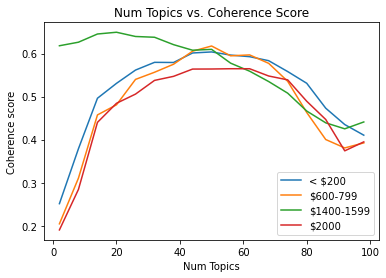

In [140]:
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_g0, label='< $200')
plt.plot(x, coherence_values_g3, label='$600-799')
plt.plot(x, coherence_values_g7, label='$1400-1599')
plt.plot(x, coherence_values_g10, label='$2000')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Num Topics vs. Coherence Score')
plt.legend()
plt.show()

It looks like around 50 topics is best for these sets.

### Run LDA on each group individually (models are saved don't need to rerun)

In [183]:
# takes about 8 min to run
models = []
corpuses = []
id2words = []
for df in dfs:
    id2word, corpus = preprocessing(df)
    corpuses.append(corpus)
    id2words.append(id2words)
    model = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=50)
    models.append(model)

In [187]:
filename = '/Users/Lucia/Documents/USF/MSDS626_Case_Studies/jeopardy-topic-modeling/data_2a/corpuses'
outfile = open(filename,'wb')
pickle.dump(corpuses, outfile)
outfile.close()

In [188]:
filename = '/Users/Lucia/Documents/USF/MSDS626_Case_Studies/jeopardy-topic-modeling/data_2a/id2words'
outfile = open(filename,'wb')
pickle.dump(id2words, outfile)
outfile.close()

In [189]:
filename = '/Users/Lucia/Documents/USF/MSDS626_Case_Studies/jeopardy-topic-modeling/data_2a/trained_models'
outfile = open(filename,'wb')
pickle.dump(models,outfile)
outfile.close()

### Load saved data

In [191]:
filename = './data_2a/corpuses'
infile = open(filename,'rb')
corpuses = pickle.load(infile)
infile.close()

In [192]:
filename = './data_2a/id2words'
infile = open(filename,'rb')
id2words = pickle.load(infile)
infile.close()

In [193]:
filename = './data_2a/trained_models'
infile = open(filename,'rb')
models = pickle.load(infile)
infile.close()

In [195]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 15);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

get_lda_topics(models[0], 50)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 41,Topic # 42,Topic # 43,Topic # 44,Topic # 45,Topic # 46,Topic # 47,Topic # 48,Topic # 49,Topic # 50
0,want,place,fight,people,win,film,use,contain,island,tell,...,part,line,capital,run,song,friend,company,know,work,feature
1,girl,show,gold,open,festival,series,keep,fruit,rock,make,...,body,begin,life,form,country,hat,introduce,foot,hold,woman
2,house,book,substance,join,roll,president,hand,mayor,brother,be,...,believe,character,night,try,family,name,should,area,sell,hear
3,award,movie,car,marry,face,add,make,ad,base,author,...,sit,sport,sea,version,color,tool,name,state,mile,town
4,university,move,attack,vote,career,talk,lake,appear,kill,help,...,metal,s,war,dress,set,grape,space,act,ship,side
5,launch,market,ring,plant,year,play,tale,display,ball,road,...,college,one,consider,seat,mean,region,hair,can,paper,king
6,relative,score,year,height,can,novel,paint,other,hit,could,...,cheese,actor,month,flower,week,s,cast,mountain,music,daughter
7,address,today,present,call,time,accord,tail,attraction,party,use,...,empire,art,job,religion,bill,pet,peace,city,basketball,start
8,disease,doctor,abbreviate,state,leader,book,arm,say,tv,vehicle,...,revolution,describe,plan,painting,hit,stone,weapon,say,system,song
9,mother,become,feel,can,language,tv,meat,boat,beach,tape,...,subtitle,change,pull,accord,ask,birth,say,mile,make,send


### Analysis of lda by value

## Split each group further by year

In [48]:
dfs_val0_year = [x for _, x in dfs[0].groupby('year')]

In [49]:
len(dfs_val0_year)

29

In [50]:
# 29 x 64 = 1856 lda models lol